# Chapter 1, figures 3 and 4

This notebook will show you how to produce figures 1.3 and 1.4 after the predictive modeling is completed.

The predictive modeling itself, unfortunately, doesn't fit in a notebook. The number-crunching can take several hours, and although logistic regression itself is not complicated, the practical details -- dates, authors, multiprocessing to speed things up, etc -- turn it into a couple thousand lines of code. (If you want to dig into that, see ```chapter1/code/biomodel.py```, and the scripts in ```/logistic``` at the top level of the repo.)

Without covering those tangled details, this notebook can still explore the results of modeling in enough depth to give you a sense of some important choices made along the way.

### Define modeling parameters

I start by finding an optimal number of features for the model, and also a value for C (the regularization constant). To do this I run a "grid search" that tests different values of both parameters. (I use the "gridsearch" option in biomodel, aka: ```python3 biomodel.py gridsearch```.) The result looks like this:

![title](gridsearch.png)

where darker red squares indicate higher accuracies. I haven't labeled the axes correctly, but the vertical axis here is number of features (from 800 to 2500), and the horizontal axis is the C parameter (from .0012 to 10, logarithmically).

It's important to use the same sample size for this test that you plan to use in the final model: in this case a rather small group of 150 volumes (75 positive and 75 negative), because I want to be able to run models in periods as small as 20 years. With such a small sample, it's important to run the gridsearch several times, since the selection of a particular 150 volumes introduces considerable random variability into the process. 

One could tune the C parameter for each sample, and I try that in a different chapter, but my experience is that it introduces complexity without actually changing results--plus I get anxious about overfitting through parameter selection. Probably better just to confirm results with multiple samples and multiple C settings. A robust result should hold up.

I've tested the differentiation of genres with multiple parameter settings, and it does hold up. But for figure 1.3, I settled on 1100 features (words) and C = 0.015 as settings that fairly consistently produce good results for the biography / fiction boundary. Then it's possible to

### Assess accuracy across time: Figure 1.3

I do this by running ```python3 biomodel.py usenewdata``` (the contrast between 'new' and 'old' metadata will become relevant later in this notebook). That produces a file of results visualized below.

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random

In [42]:
accuracy_df = pd.read_csv('../modeloutput/finalbiopredicts.csv')
accuracy_df.head()

,center,accuracy
0,1720,0.940000
1,1720,0.913333
2,1720,0.946667
3,1720,0.940000
4,1720,0.933333


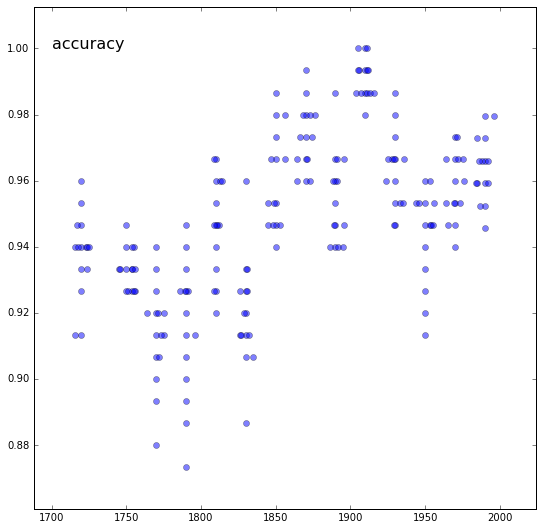

In [62]:
# I "jitter" results horizontally because we often have multiple results with the same x and y coordinates.

def jitteraframe(df, yname):
    jitter = dict()
    for i in df.index:
        x = df.loc[i, 'center']
        y = df.loc[i, yname]

        if x not in jitter:
            jitter[x] = set()
        elif y in jitter[x]:
            dodge = random.choice([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
            x = x + dodge
            df.loc[i, 'center'] = x
            if x not in jitter:
                jitter[x] = set()

        jitter[x].add(y)

jitteraframe(accuracy_df, 'accuracy')
        
fig, ax = plt.subplots(figsize = (9, 9))
ax.margins(0.1)
ax.plot(accuracy_df.center, accuracy_df.accuracy, marker = 'o', linestyle = '', alpha = 0.5)
ax.annotate('accuracy', xy = (1700,1), fontsize = 16)
plt.show()

#### assessment

There's a lot of random variation with this small sample size, but it's still perfectly clear that accuracy rises across this timeline. It may not be a linear relationship: it looks like the boundary between fiction and biography may be sharpest around 1910, and rather than a smooth line, it might be two regimes divided around 1850. But it's still quite clear that accuracy rises: if we modeled it simply as a linear correlation, it would be strong and significant.

In [35]:
from scipy.stats import pearsonr
pearsonr(accuracy_df.floor, accuracy_df.accuracy)

(0.54427832507144336, 1.3614756409125197e-17)

The first number is the correlation coefficient; the second a p value.

### Plotting individual volume probabilities: Figure 1.4

In a sense plotting individual volumes is extremely simple. My modeling process writes files that record the metadata for each volume along with a column **logistic** that reports the predicted probability of being in the positive class (in this case, fiction). We can just plot the probabilities on the y axis, and dates used for modeling on the x axis. Have done that below.

In [14]:
root = '../modeloutput/'
frames = []
for floor in range(1700, 2000, 50):
    sourcefile = root + 'theninehundred' + str(floor) + '.csv'
    thisframe = pd.read_csv(sourcefile)
    frames.append(thisframe)

df = pd.concat(frames)
df.head()

,volid,dateused,pubdate,birthdate,firstpub,gender,nation,allwords,logistic,realclass,trainflag,trainsize,author,title,genretags
0,dul1.ark+=13960=t1cj99q4g,1741,1741,1741,1741,NaN,NaN,22103,0.454529,0,1,149,"Oldys, William,",Memoirs of Mrs. Anne Oldfield,bio
1,nnc1.0037104098,1739,1739,1739,1739,NaN,NaN,86025,0.669344,1,1,149,"Challes, Robert,",The illustrious French lovers;,fic
2,dul1.ark+=13960=t74t7bs0b,1735,1735,1735,1735,NaN,NaN,127228,0.650335,1,1,148,"Chetwood, W. R.",The voyages and adventures of Captain Robert B...,fic
3,uva.x030809128,1715,1715,1715,1715,NaN,NaN,156048,0.451771,0,1,149,"Whiting, John,","Persecution expos'd, in some memoirs relating ...",bio
4,mdp.39015004752112,1725,1725,1725,1725,NaN,NaN,472248,0.474368,0,1,149,"Boyle, Robert,",The philosophical works of the Honourable Robe...,bio


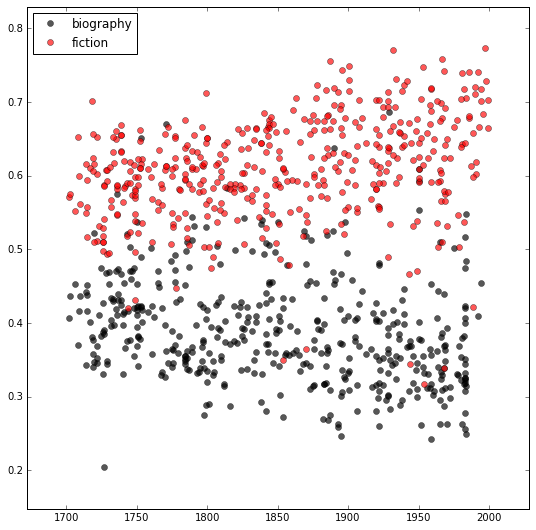

In [15]:
groups = df.groupby('realclass')
groupnames = {0: 'biography', 1: 'fiction'}
groupcolors = {0: 'k', 1: 'r'}
fig, ax = plt.subplots(figsize = (9, 9))

ax.margins(0.1)
for code, group in groups:
    ax.plot(group.dateused, group.logistic, marker='o', linestyle='', ms=6, alpha = 0.66, color = groupcolors[code], label=groupnames[code])
ax.legend(numpoints = 1, loc = 'upper left')

plt.show()

#### caveats

The pattern you see above is real, and makes a nice visual emblem of generic differentiation. However, there are some choices involved worth reflection. The probabilities plotted above were produced by six models, trained on 50-year segments of the timeline, using 1100 features **and a C setting of 0.00008**. That C setting works fine, but it's much lower than the one I chose as optimal for assessing accuracy. What happens if we use instead C = 0.015, and in fact simply reuse the evidence from figure 1.3 unchanged?

The accuracies recorded in ```finalpredictbio.csv``` come from a series of models named ```cleanpredictbio``` (plus some more info). I haven't saved all of them, but we have the last model in each sequence of 15. We can plot those probabilities.

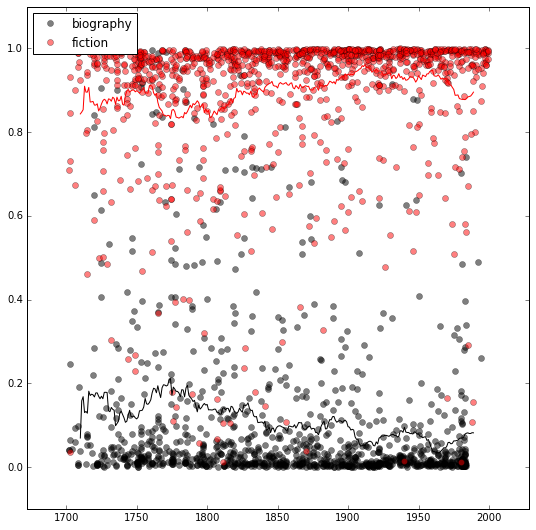

In [73]:
root = '../modeloutput/'
frames = []
for floor in range(1700, 2000, 20):
    if floor == 1720:
        continue
        # the first model covers 40 years
    sourcefile = root + 'cleanpredictbio' + str(floor) + '2017-10-15.csv'
    thisframe = pd.read_csv(sourcefile)
    frames.append(thisframe)

df = pd.concat(frames)

bio = []
fic = []
for i in range (1710, 1990):
    segment = df[(df.dateused > (i - 10)) & (df.dateused < (i + 10))]
    bio.append(np.mean(segment[segment.realclass == 0].logistic))
    fic.append(np.mean(segment[segment.realclass == 1].logistic))
    
groups = df.groupby('realclass')
groupnames = {0: 'biography', 1: 'fiction'}
groupcolors = {0: 'k', 1: 'r'}
fig, ax = plt.subplots(figsize = (9, 9))

ax.margins(0.1)
for code, group in groups:
    ax.plot(group.dateused, group.logistic, marker='o', linestyle='', ms=6, alpha = 0.5, color = groupcolors[code], label=groupnames[code])
ax.plot(list(range(1710,1990)), bio, c = 'k')
ax.plot(list(range(1710,1990)), fic, c = 'r')
ax.legend(numpoints = 1, loc = 'upper left')

plt.show()

Whoa, that's a different picture!

If you look closely, there's still a pattern of differentiation: probabilities are more dispersed in the early going, and probs of fiction and biography overlap more. Later on, a space opens up between the genres. I've plotted the mean trend lines to confirm the divergence. 

But the picture *looks* very different. This model uses less aggressive regularization (the bigger C constant makes it more confident), so most probabilities hit the walls around 1.0 or 0.0. 

This makes it less obvious, visually, that differentiation is a phenomenon affecting the whole genre. We actually *do* see a significant change in medians here, as well as means. But it would be hard to see with your eyeballs, because the trend lines are squashed toward the edges.

So I've chosen to use more aggressive regularization (and a smaller number of examples) for the illustration in the book. That's a debatable choice, and a consequential one: as I acknowledge above, it changes the way we understand the word *differentiation.* I think there are valid reasons for the choice. Neither of the illustrations above is "truer" than than the other; they are alternate, valid perspectives on the same evidence. But if you want to use this kind of visualization, it's important to recognize that tuning the regularization constant will very predictably give you this kind of choice. It can't make a pattern of differentiation appear out of thin air, but it absolutely does change the distribution of probabilities across the y axis. It's a visual-rhetorical choice that needs acknowledging.